## Electricity Consumption Forecasting Using ESN

This dataset contains six months of electricity consumption data for a household, gathered between January 2007 and June 2007. We are interested in predictive modelling using ESN on this dataset.

* Date: The date of the observation.
* Time: The time of the observation.
* Global_active_power: The total active power consumed by the household (kilowatts).
* Global_reactive_power: The total reactive power consumed by the household (kilowatts).
* Voltage: The voltage at which the electricity is delivered to the household (volts). 
* Global_intensity: The average current intensity delivered to the household (amps).
* Sub_metering_1: The active power consumed by the kitchen (kilowatts). 
* Sub_metering_2: The active power consumed by the laundry room (kilowatts). 
* Sub_metering_3: The active power consumed by the electric water heater and air conditioner (kilowatts). 

Objectives:
1. Predict electricity consumption (global active power) using ESN.
2. Identify the accuracy of using ESN on this dataset.

## Step 1: Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyESN import ESN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
# Load the dataset
data = pd.read_csv('household_power_consumption.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  260640 non-null  int64  
 1   Date                   260640 non-null  object 
 2   Time                   260640 non-null  object 
 3   Global_active_power    260640 non-null  object 
 4   Global_reactive_power  260640 non-null  object 
 5   Voltage                260640 non-null  object 
 6   Global_intensity       260640 non-null  object 
 7   Sub_metering_1         260640 non-null  object 
 8   Sub_metering_2         260640 non-null  object 
 9   Sub_metering_3         256869 non-null  float64
dtypes: float64(1), int64(1), object(8)
memory usage: 19.9+ MB


In [3]:
data.head()

,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0,1/1/07,0:00:00,2.58,0.136,241.97,10.6,0,0,0.0
1,1,1/1/07,0:01:00,2.552,0.1,241.75,10.4,0,0,0.0
2,2,1/1/07,0:02:00,2.55,0.1,241.64,10.4,0,0,0.0
3,3,1/1/07,0:03:00,2.55,0.1,241.71,10.4,0,0,0.0
4,4,1/1/07,0:04:00,2.554,0.1,241.98,10.4,0,0,0.0


## Step 2: Data cleaning

In [4]:
data.duplicated().sum()

0

There are no duplicate rows in the dataset.

In [5]:
# Drop rows with missing values
data = data.dropna()

# Drop the index column
data = data.drop('index',axis=1)

# Check the number of remaining rows
data.shape

(256869, 9)

After dropping the rows with missing values, we now have 256,869 rows of data left.

In [6]:
# Combine 'Date' and 'Time' into a single datetime column
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('datetime', inplace=True)

In [7]:
# Drop 'Date' and 'Time' columns, keeping only the relevant columns
data = data[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
             'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

In [8]:
# Change data types to float
data['Global_reactive_power'] = data['Global_reactive_power'].astype(float)
data['Voltage'] = data['Voltage'].astype(float)
data['Global_intensity'] = data['Global_intensity'].astype(float)
data['Sub_metering_1'] = data['Sub_metering_1'].astype(float)
data['Sub_metering_2'] = data['Sub_metering_2'].astype(float)
data['Sub_metering_3'] = data['Sub_metering_3'].astype(float)

In [9]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-01-01 00:00:00,2.58,0.136,241.97,10.6,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0
2007-01-01 00:02:00,2.55,0.100,241.64,10.4,0.0,0.0,0.0
2007-01-01 00:03:00,2.55,0.100,241.71,10.4,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 256869 entries, 2007-01-01 00:00:00 to 2007-06-30 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    256869 non-null  object 
 1   Global_reactive_power  256869 non-null  float64
 2   Voltage                256869 non-null  float64
 3   Global_intensity       256869 non-null  float64
 4   Sub_metering_1         256869 non-null  float64
 5   Sub_metering_2         256869 non-null  float64
 6   Sub_metering_3         256869 non-null  float64
dtypes: float64(6), object(1)
memory usage: 15.7+ MB


## Step 3: Data Visualization

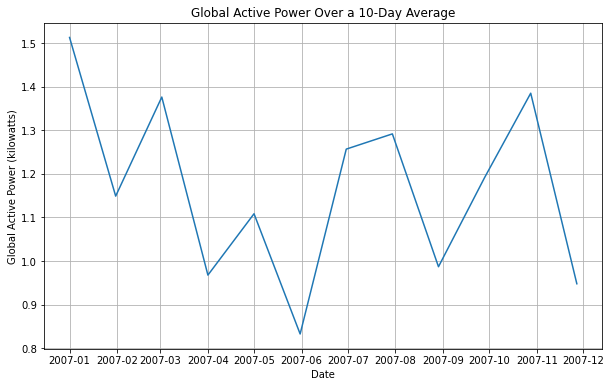

In [11]:
# datetime index and 'Global_active_power' column
data['Global_active_power'] = data['Global_active_power'].astype(float)
global_active_power_10d = data['Global_active_power'].resample('30D').mean()

# Plot the data
plt.figure(figsize=(10, 6))

# 10-day average plot
plt.plot(global_active_power_10d.index, global_active_power_10d)

# Add titles and labels
plt.title('Global Active Power Over a 10-Day Average')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.show()


## Step 4: Predict using ESN

In [12]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Prepare input and output
X = data_normalized[:-1]  # All rows except the last one as inputs
y = data_normalized[1:, 0]  # The next time step's Global_active_power as the target

# Step 4: Split the data into train and test sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
#Remove NaN values
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Initialize the ESN
esn = ESN(n_inputs=X_train.shape[1], n_outputs=1, n_reservoir=300, sparsity=0.2, random_state=42)

In [16]:
# Train the ESN on the training data
pred_train = esn.fit(X_train, y_train)

# Test the ESN on test data
pred_test = esn.predict(X_test)

# Inverse scale the predictions to get original scale
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, 1:]), axis=1))[:, 0]
pred_test_actual = scaler.inverse_transform(np.concatenate((pred_test.reshape(-1, 1), X_test[:, 1:]), axis=1))[:, 0]

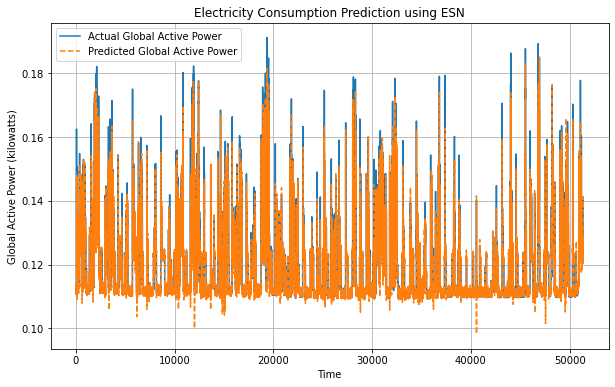

In [17]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Global Active Power')
plt.plot(pred_test_actual, label='Predicted Global Active Power', linestyle='dashed')
plt.legend()
plt.title('Electricity Consumption Prediction using ESN')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.grid(True)
plt.show()

In [18]:
def error_summary(y_actual, y_pred):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")

# Call the function
error_summary(y_test_actual, pred_test_actual)

Mean Absolute Error: 0.001358497561775728
Mean Squared Error: 9.864416915205563e-06
Root Mean Squared Error: 0.0031407669310545097
R-squared: 0.9108555850510708


# Conclusion

With a RMSE of 0.3%, we discovered that ESN is a highly suitable model to predict active electricity consumption in households.